<a href="https://colab.research.google.com/github/Arman001/fraud-deteciton-ml/blob/main/Fraud_Detection_and_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fraud Detection with Machine Learning**
***
### **By:** Muhammad Saad
***


## Install cuML

We need to install **RAPIDS cuML** because


*   It is similar to sklaern
*   It provides GPU-accelerated models which we need for this huge dataset as CPU based training will take a ton of time.

Installation can take a bit of time so be patient.



In [ ]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
# Uninstall older packages (if applicable)
!pip uninstall -y cupy-cuda11x
!pip uninstall -y cuml-cu11 cudf-cu11

# Install cuML, cuDF, and pandas with compatibility for CUDA 12.2
!pip install --extra-index-url=https://pypi.nvidia.com cudf-cu12 cuml-cu12

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.7/567.7 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 836.6/836.6 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.9/196.9 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.7/722.7 kB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 916.0/916.0 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.6/242.6 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install joblib

## Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import time
# Cuml-based counterpart of sklearn
import cudf
from cuml.metrics import accuracy_score, roc_auc_score
from cuml.preprocessing import StandardScaler
from cuml.model_selection import train_test_split

# Precision score not available in cuml
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc,confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize


## Load the dataset


In [ ]:
# You can download the dataset from this link https://drive.google.com/file/d/1dCgctWx97hi68Hvsp9MYr_UxcMBYO5PO/view?usp=drive_link
# Upload it in the files section

dataset = cudf.read_csv('creditcard_2023.csv')

In [ ]:
dataset.shape

(568630, 31)

In [ ]:
dataset.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


In [ ]:
dataset.columns
# The Columns through V1 to V28 are anonymized to protect the cardholders' identities.

Index(['id', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

## Data Preprocessing

### Data Cleaning

In [ ]:
# checking for missing values
missing_values = dataset.isnull().sum()
missing_values

id        0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

 There are no null values here this is good news

### Feature Engineering

We don't need this step here

### Checking for Dataset Balance

In [ ]:
# Let's check how much transactions are fraudlent and how much are genuine
transaction_counts = dataset['Class'].value_counts()

transaction_counts


Class
1    284315
0    284315
Name: count, dtype: int64

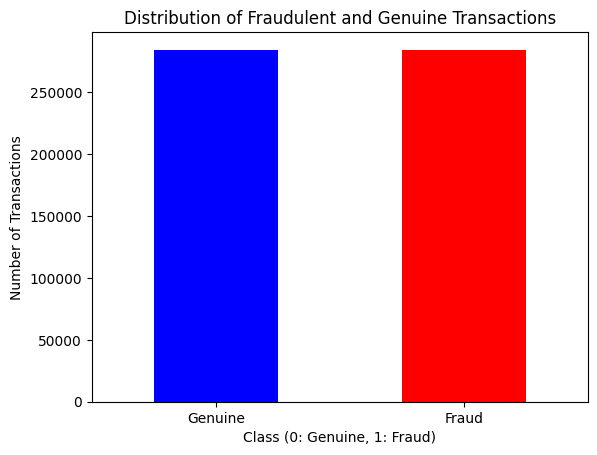

In [ ]:
# Plot the distribution of the 'Class' column
dataset['Class'].value_counts().to_pandas().plot(kind='bar', color=['blue', 'red'])
plt.title('Distribution of Fraudulent and Genuine Transactions')
plt.xlabel('Class (0: Genuine, 1: Fraud)')
plt.ylabel('Number of Transactions')
plt.xticks(ticks=[0, 1], labels=['Genuine', 'Fraud'], rotation=0)
plt.show()

It is a perfectly balanced dataset we can move further

### Feature Scaling

In [ ]:
# Other values are scaled perfectly we can scale amount column for models like SVM
scaler = StandardScaler()
dataset['Amount'] = scaler.fit_transform(dataset[['Amount']])


In [ ]:
dataset.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,0.858447,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,-0.796369,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,-1.377011,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,-0.962119,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,0.323285,0


### Splitting into Train and Test Datasets

In [ ]:
X = dataset.drop(columns=['id','Class'])  # All columns except the target column and id column
y = dataset['Class']  # Target column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert features to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

#Conversion to int32 for compatibility
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

In [ ]:
print ('X_train shape', X_train.shape)
print ('X_test shape', X_test.shape)
print ('y_train shape', y_train.shape)
print ('y_test shape', y_test.shape)


X_train shape (454904, 29)
X_test shape (113726, 29)
y_train shape (454904,)
y_test shape (113726,)


## Training Different Models


### 1. Logistic Regression

#### Training The Model

In [ ]:
from cuml.linear_model import LogisticRegression
lr_model = LogisticRegression()

In [ ]:
start_time = time.time()
lr_model.fit(X_train, y_train)
end_time = time.time()

training_time_lr = end_time - start_time
print(f"Training time Logistic Regressopm: {training_time_lr:.2f} seconds")

Training time Logistic Regressopm: 3.04 seconds


#### Making Predictions

In [ ]:
# Predict on the test set
lr_y_pred = lr_model.predict(X_test)
type(X_test)
lr_y_pred_prob = lr_model.predict_proba(X_test.to_pandas())[1]  # Probabilities for ROC-AUC calculation

#### Evaluate the Model

#####  a.  Accuracy, Precision, Recall, and F1-Score


In [ ]:
# Print evaluation metrics
lr_accuracy = accuracy_score(y_test, lr_y_pred)
lr_precision = precision_score(y_test.to_numpy(), lr_y_pred.to_numpy())
lr_recall = recall_score(y_test.to_numpy(), lr_y_pred.to_numpy())
lr_f1 = f1_score(y_test.to_numpy(), lr_y_pred.to_numpy())

print(f'Accuracy: {lr_accuracy:.4f}')
print(f'Precision: {lr_precision:.4f}')
print(f'Recall: {lr_recall:.4f}')
print(f'F1 Score: {lr_f1:.4f}')

Accuracy: 0.9649
Precision: 0.9771
Recall: 0.9521
F1 Score: 0.9644


##### b. ROC-AUC Score

In [ ]:
lr_roc_auc = roc_auc_score(y_test, lr_y_pred_prob)
print(f'ROC-AUC Score: {lr_roc_auc:.4f}')

ROC-AUC Score: 0.9935


##### c. Classification Report

In [ ]:
print("Classification Report:\n", classification_report(y_test.to_numpy(), lr_y_pred.to_numpy()))


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97     56863
           1       0.98      0.95      0.96     56863

    accuracy                           0.96    113726
   macro avg       0.97      0.96      0.96    113726
weighted avg       0.97      0.96      0.96    113726



##### d. Confusion Matrix

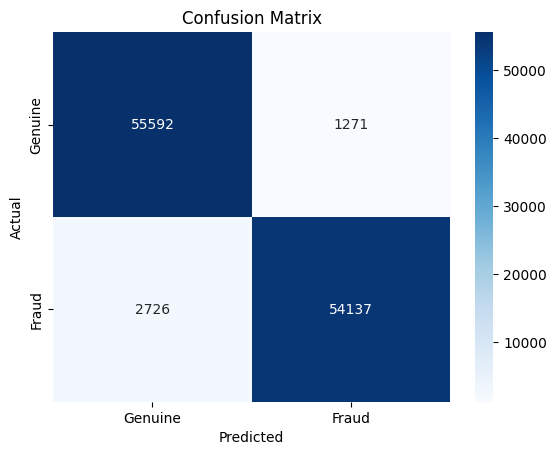

In [ ]:
# Plot the confusion matrix for a better visualization
lr_cm = confusion_matrix(y_test.to_numpy(), lr_y_pred.to_numpy())
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Genuine', 'Fraud'], yticklabels=['Genuine', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### 2. Random Forest

#### Training The Model

In [ ]:
from cuml.ensemble import RandomForestClassifier

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100)


In [ ]:
start_time = time.time()

rf_model.fit(X_train, y_train)

end_time = time.time()

training_time_rf = end_time - start_time
print(f"Training time Random Forest: {training_time_rf:.2f} seconds")

Training time Random Forest: 2.42 seconds


#### Making Predictions

In [ ]:
# Predict on the test set
rf_y_pred = rf_model.predict(X_test)
rf_y_pred_prob = rf_model.predict_proba(X_test.to_pandas())[1]  # Probabilities for ROC-AUC calculation

#### Evaluate the Model

#####  a.  Accuracy, Precision, Recall, and F1-Score


In [ ]:
# Print evaluation metrics
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test.to_numpy(), rf_y_pred.to_numpy())
rf_recall = recall_score(y_test.to_numpy(), rf_y_pred.to_numpy())
rf_f1 = f1_score(y_test.to_numpy(), rf_y_pred.to_numpy())

print(f'Accuracy: {rf_accuracy:.4f}')
print(f'Precision: {rf_precision:.4f}')
print(f'Recall: {rf_recall:.4f}')
print(f'F1 Score: {rf_f1:.4f}')

Accuracy: 0.9995
Precision: 0.9994
Recall: 0.9997
F1 Score: 0.9995


##### b. ROC-AUC Score

In [ ]:
rf_roc_auc = roc_auc_score(y_test.to_numpy(), rf_y_pred_prob.to_numpy())
print(f'ROC-AUC Score: {rf_roc_auc:.4f}')

ROC-AUC Score: 1.0000


##### c. Classification Report

In [ ]:
print("Classification Report:\n", classification_report(y_test.to_numpy(), rf_y_pred.to_numpy()))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



##### d. Confusion Matrix

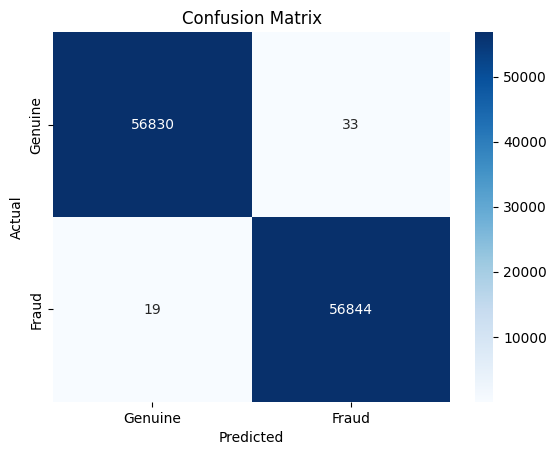

In [ ]:
# Plot the confusion matrix for a better visualization
rf_cm = confusion_matrix(y_test.to_numpy(), rf_y_pred.to_numpy())
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Genuine', 'Fraud'], yticklabels=['Genuine', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### 3. Support Vector Machine (Linear Kernel)

#### Training The Model

In [ ]:
from cuml.svm import SVC


# Initialize the SVM model
svm_model = SVC(kernel='linear', probability=True)


In [ ]:
start_time = time.time()
svm_model.fit(X_train, y_train)
end_time = time.time()

training_time_svm = end_time - start_time
print(f"Training time SVM (Linear Kernel): {training_time_svm:.2f} seconds")

Training time SVM (Linear Kernel): 58.29 seconds


#### Making Predictions

In [ ]:
# Predict on the test set
svm_y_pred = svm_model.predict(X_test)
svm_y_pred_prob = svm_model.predict_proba(X_test.to_pandas())[1]  # Probabilities for ROC-AUC calculation

#### Evaluate the Model

#####  a.  Accuracy, Precision, Recall, and F1-Score


In [ ]:
# Print evaluation metrics
svm_accuracy = accuracy_score(y_test, svm_y_pred)
svm_precision = precision_score(y_test.to_numpy(), svm_y_pred.to_numpy())
svm_recall = recall_score(y_test.to_numpy(), svm_y_pred.to_numpy())
svm_f1 = f1_score(y_test.to_numpy(), svm_y_pred.to_numpy())

print(f'Accuracy: {svm_accuracy:.4f}')
print(f'Precision: {svm_precision:.4f}')
print(f'Recall: {svm_recall:.4f}')
print(f'F1 Score: {svm_f1:.4f}')

Accuracy: 0.9656
Precision: 0.9785
Recall: 0.9521
F1 Score: 0.9651


##### b. ROC-AUC Score

In [ ]:
svm_roc_auc = roc_auc_score(y_test, svm_y_pred_prob)
print(f'ROC-AUC Score: {svm_roc_auc:.4f}')

ROC-AUC Score: 0.9931


##### c. Classification Report

In [ ]:
print("Classification Report:\n", classification_report(y_test.to_numpy(), svm_y_pred.to_numpy()))


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97     56863
           1       0.98      0.95      0.97     56863

    accuracy                           0.97    113726
   macro avg       0.97      0.97      0.97    113726
weighted avg       0.97      0.97      0.97    113726



##### d. Confusion Matrix

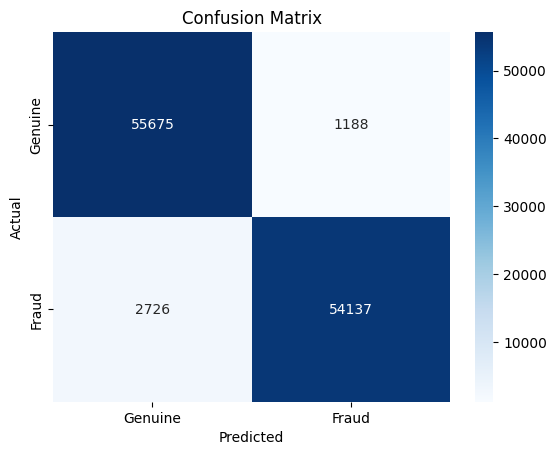

In [ ]:
# Plot the confusion matrix for a better visualization
svm_cm = confusion_matrix(y_test.to_numpy(), svm_y_pred.to_numpy())
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Genuine', 'Fraud'], yticklabels=['Genuine', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### 4. Support Vector Machine (RBF Kernel)

#### Training The Model

In [ ]:
from cuml.svm import SVC


# Initialize the SVM model
svm_rbf_model = SVC(kernel='rbf', gamma='scale', C=1, probability=True)



In [ ]:
start_time = time.time()
svm_rbf_model.fit(X_train, y_train)
end_time = time.time()

training_time_svm_rbf = end_time - start_time
print(f"Training time SVM (RBF Kernel): {training_time_svm_rbf:.2f} seconds")

Training time SVM (RBF Kernel): 14.54 seconds


#### Making Predictions

In [ ]:
# Predict on the test set
svm_rbf_y_pred = svm_model.predict(X_test)
svm_rbf_y_pred_prob = svm_rbf_model.predict_proba(X_test.to_pandas())[1]  # Probabilities for ROC-AUC calculation

#### Evaluate the Model

#####  a.  Accuracy, Precision, Recall, and F1-Score


In [ ]:
# Print evaluation metrics
svm_rbf_accuracy = accuracy_score(y_test, svm_rbf_y_pred)
svm_rbf_precision = precision_score(y_test.to_numpy(), svm_rbf_y_pred.to_numpy())
svm_rbf_recall = recall_score(y_test.to_numpy(), svm_rbf_y_pred.to_numpy())
svm_rbf_f1 = f1_score(y_test.to_numpy(), svm_rbf_y_pred.to_numpy())

print(f'Accuracy: {svm_rbf_accuracy:.4f}')
print(f'Precision: {svm_rbf_precision:.4f}')
print(f'Recall: {svm_rbf_recall:.4f}')
print(f'F1 Score: {svm_rbf_f1:.4f}')

Accuracy: 0.9656
Precision: 0.9785
Recall: 0.9521
F1 Score: 0.9651


##### b. ROC-AUC Score

In [ ]:
svm_rbf_roc_auc = roc_auc_score(y_test, svm_rbf_y_pred_prob)
print(f'ROC-AUC Score: {svm_rbf_roc_auc:.4f}')

ROC-AUC Score: 0.9998


##### c. Classification Report

In [ ]:
print("Classification Report:\n", classification_report(y_test.to_numpy(), svm_rbf_y_pred.to_numpy()))


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97     56863
           1       0.98      0.95      0.97     56863

    accuracy                           0.97    113726
   macro avg       0.97      0.97      0.97    113726
weighted avg       0.97      0.97      0.97    113726



##### d. Confusion Matrix

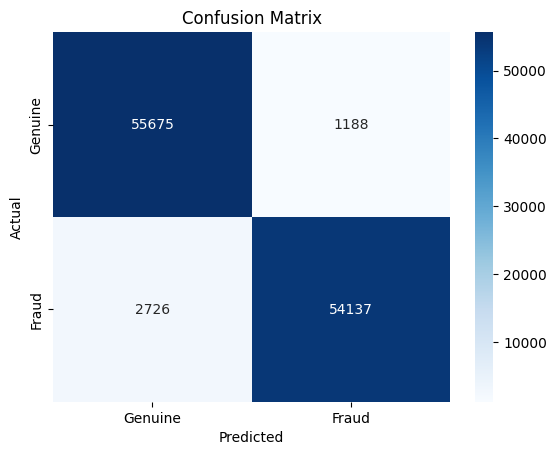

In [ ]:
# Plot the confusion matrix for a better visualization
svm_rbf_cm = confusion_matrix(y_test.to_numpy(), svm_rbf_y_pred.to_numpy())
sns.heatmap(svm_rbf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Genuine', 'Fraud'], yticklabels=['Genuine', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Comparision

### Table of Metrices

In [ ]:
comparision_data = {
    'Model': ['Logistic Regression', 'Random Forest', 'SVM (Linear Kernel)', 'SVM (RBF)'],
    'Accuracy': [lr_accuracy, rf_accuracy, svm_accuracy, svm_rbf_accuracy],
    'Precision': [lr_precision, rf_precision, svm_precision, svm_rbf_precision],
    'Recall': [lr_recall, rf_recall, svm_recall, svm_rbf_recall],
    'F1-Score': [lr_f1, rf_f1, svm_f1, svm_rbf_f1],
    'ROC AUC': [lr_roc_auc, rf_roc_auc, svm_roc_auc, svm_rbf_roc_auc]
}

In [ ]:
# Convert dictionary into a pandas DataFrame
df = cudf.DataFrame(comparision_data)

In [ ]:
df.set_index('Model', inplace=True)
df

,Accuracy,Precision,Recall,F1-Score,ROC AUC
Model,,,,,
Logistic Regression,0.964854,0.977061,0.952060,0.964399,0.993506
Random Forest,0.999543,0.999420,0.999666,0.999543,0.999962
SVM (Linear Kernel),0.965584,0.978527,0.952060,0.965112,0.993143
SVM (RBF),0.965584,0.978527,0.952060,0.965112,0.999780


### ROC Curve

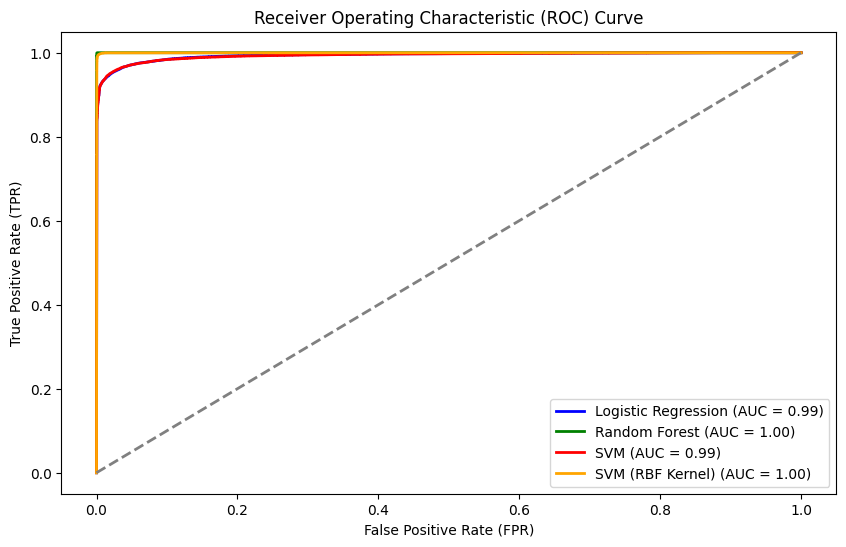

In [ ]:
# Compute ROC curve and AUC
fpr_lr, tpr_lr, _ = roc_curve(y_test.to_numpy(), lr_y_pred_prob.to_numpy())
fpr_rf, tpr_rf, _ = roc_curve(y_test.to_numpy(), rf_y_pred_prob.to_numpy())
fpr_svm, tpr_svm, _ = roc_curve(y_test.to_numpy(), svm_y_pred_prob.to_numpy())
fpr_svm_rbf, tpr_svm_rbf, _ = roc_curve(y_test.to_numpy(), svm_rbf_y_pred_prob.to_numpy())

roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_svm = auc(fpr_svm, tpr_svm)
roc_auc_svm_rbf = auc(fpr_svm_rbf, tpr_svm_rbf)


# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_svm, tpr_svm, color='red', lw=2, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot(fpr_svm_rbf, tpr_svm_rbf, color='orange', lw=2, label=f'SVM (RBF Kernel) (AUC = {roc_auc_svm_rbf:.2f})')

# Plot a diagonal line (chance line)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Labels and title
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')

# Show the plot
plt.show()

### Confusion Matrices

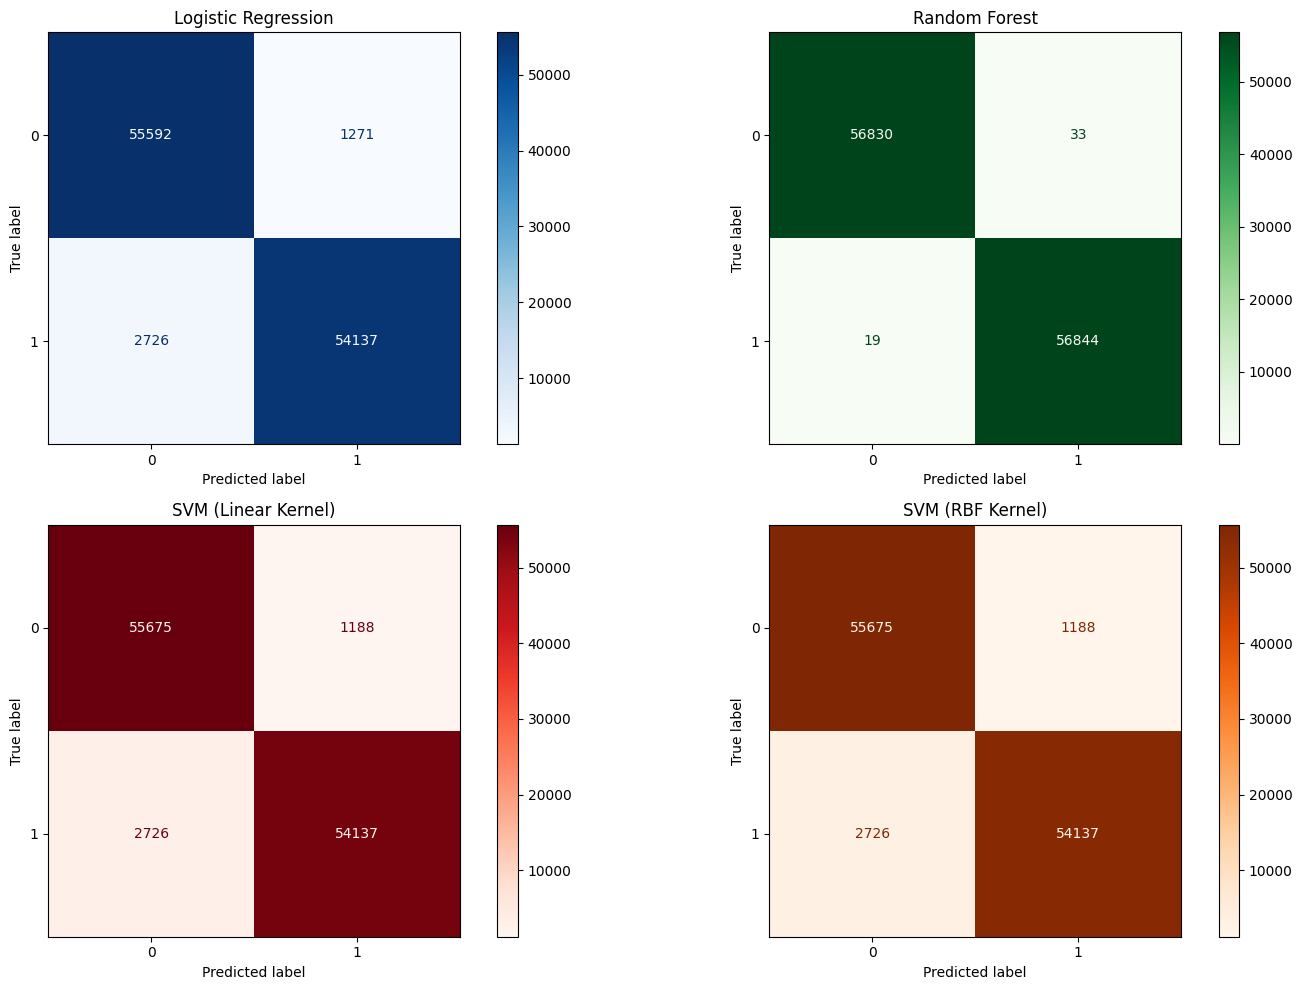

In [ ]:
# Create 2x2 grid for subplots (leave the last one empty)
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot the confusion matrices
ConfusionMatrixDisplay(lr_cm).plot(ax=axs[0, 0], cmap='Blues')
axs[0, 0].set_title('Logistic Regression')

ConfusionMatrixDisplay(rf_cm).plot(ax=axs[0, 1], cmap='Greens')
axs[0, 1].set_title('Random Forest')

ConfusionMatrixDisplay(svm_cm).plot(ax=axs[1, 0], cmap='Reds')
axs[1, 0].set_title('SVM (Linear Kernel)')

ConfusionMatrixDisplay(svm_rbf_cm).plot(ax=axs[1, 1], cmap='Oranges')
axs[1, 1].set_title('SVM (RBF Kernel)')


# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### Training Time

In [ ]:
training_time = {
    'Model': ['Logistic Regression', 'Random Forest', 'SVM (Linear Kernel)', 'SVM (RBF)'],
    'Training Time': [training_time_lr, training_time_rf, training_time_svm, training_time_svm_rbf],
}

df = cudf.DataFrame(training_time)
df


,Model,Training Time
0,Logistic Regression,3.043894
1,Random Forest,2.416386
2,SVM (Linear Kernel),58.286125
3,SVM (RBF),14.536175


## Serializing Models

In [ ]:
# Save models
joblib.dump(lr_model, 'lr_model.pkl')
joblib.dump(rf_model, 'rf_model.pkl')
joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(svm_rbf_model, 'svm_rbf_model.pkl')

print("Models saved successfully!")

Models saved successfully!
